<a href="https://colab.research.google.com/github/Axel-Bravo/19_project_kf/blob/paula/002_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Autenticación del Kaggle con el fichero json**

In [0]:
import zipfile
from google.colab import auth
auth.authenticate_user()

In [0]:
import os
os.environ['paularl'] = "02ad3824c3a27b3ecda7ccf146ab17f2"

In [0]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paularl","key":"02ad3824c3a27b3ecda7ccf146ab17f2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 May  3 07:25 kaggle.json
{"username":"paularl","key":"02ad3824c3a27b3ecda7ccf146ab17f2"}

In [7]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 5.3MB 8.9MB/s 
     |████████████████████████████████| 102kB 33.7MB/s 
     |████████████████████████████████| 51kB 21.7MB/s 


## **Download de los datos**

In [8]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 45.0MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 46.8MB/s]
 98% 1.28G/1.30G [00:15<00:00, 98.0MB/s]
100% 1.30G/1.30G [00:15<00:00, 90.8MB/s]
100% 4.97G/4.98G [00:44<00:00, 114MB/s] 
100% 4.98G/4.98G [00:44<00:00, 121MB/s]


## **Descomprimir (unzip)**

La carpeta de test tiene que tener una carpeta 'hija', en este caso test/test para que keras lo entienda en el flow_from_directory


In [0]:
zipf = zipfile.ZipFile('../content/train.zip')
zipf.extractall('../content/train')

In [0]:
zipf = zipfile.ZipFile('../content/test.zip')
zipf.extractall('../content/test/test')

In [0]:
! rm -r ../content/train_labels.csv
zipf = zipfile.ZipFile('../content/train_labels.csv.zip')
zipf.extractall()

## Leer el fichero csv que sirve de guía conectando las imagenes con sus labels

Hay que añadir el .tif a la colunna id para que keras pueda localizar las imagenes con la funcción flow_from_dataframe. Con esta función no hace falta dividir las imagenes en dos carpatas. Keras se encarga, a partir del dataframe, de conectar cada imagen en la carpeta única '/train' a su label.


In [0]:
import pandas as pd

In [23]:
df = pd.read_csv('../content/train_labels.csv')

df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x: x+'.tif')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


## **Split en Validation/Train**

In [0]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

## Image Generator para data augmetation usando flow_from_dataframe

In [0]:
import keras
from keras_preprocessing.image import ImageDataGenerator

In [26]:
datagen=ImageDataGenerator(rescale=1./255,
                          rotation_range=45,
                          horizontal_flip=True,
                          vertical_flip=True,
                          )

train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=256)

valid_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=256)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


## **Prueba de dibujar las imagenes - Saltar!**

Found 176020 images belonging to 2 classes.


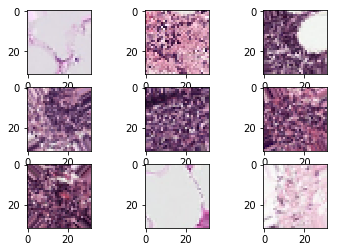

In [17]:
from matplotlib import pyplot as plt
train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=32)


for x,y in train_generator:
  for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x[i])
  break


## Red 1 - Basada en VGG16

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
input_shape = (32, 32, 3)

#Instantiate an empty model
model = Sequential([
                    Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
 #                   Conv2D(64, (3, 3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
 #                   Conv2D(128, (3, 3), activation='relu', padding='same'),
                    Conv2D(128, (3, 3), activation='relu', padding='same',),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
 #                   Conv2D(256, (3, 3), activation='relu', padding='same',),
                    Conv2D(256, (3, 3), activation='relu', padding='same',),
 #                   Conv2D(256, (3, 3), activation='relu', padding='same',),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
 #                   Conv2D(512, (3, 3), activation='relu', padding='same',),
 #                   Conv2D(512, (3, 3), activation='relu', padding='same',),
 #                   Conv2D(512, (3, 3), activation='relu', padding='same',),
 #                   MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
 #                   Conv2D(512, (3, 3), activation='relu', padding='same',),
                    Conv2D(512, (3, 3), activation='relu', padding='same',),
                    Conv2D(512, (3, 3), activation='relu', padding='same',),
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                    Flatten(),
                    Dense(4096, activation='relu'),
  #                  Dense(4096, activation='relu'),
                    Dense(2, activation='softmax')
                  ])

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv

In [28]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
687/687 [==============================] - 607s 884ms/step - loss: 0.4907 - acc: 0.7689 - val_loss: 0.4596 - val_acc: 0.7862
Epoch 2/10
687/687 [==============================] - 546s 795ms/step - loss: 0.4147 - acc: 0.8126 - val_loss: 0.4233 - val_acc: 0.8083
Epoch 3/10
687/687 [==============================] - 521s 759ms/step - loss: 0.3889 - acc: 0.8258 - val_loss: 0.3686 - val_acc: 0.8371
Epoch 4/10
687/687 [==============================] - 497s 724ms/step - loss: 0.3709 - acc: 0.8351 - val_loss: 0.3573 - val_acc: 0.8462
Epoch 5/10
687/687 [==============================] - 481s 700ms/step - loss: 0.3577 - acc: 0.8429 - val_loss: 0.3432 - val_acc: 0.8512
Epoch 6/10
687/687 [==============================] - 490s 713ms/step - loss: 0.3428 - acc: 0.8498 - val_loss: 0.3328 - val_acc: 0.8584
Epoch 7/10
687/687 [==============================] - 488s 711ms/step - loss: 0.3314 - acc: 0.8559 - val_loss: 0.3623 - val_acc: 0.8405


## Red 2 - La misma que el challange anterior (plant_seed)

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [34]:
model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         401536    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
__________

In [35]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
687/687 [==============================] - 468s 681ms/step - loss: 0.4819 - acc: 0.7730 - val_loss: 0.4438 - val_acc: 0.7973
Epoch 2/10
687/687 [==============================] - 464s 676ms/step - loss: 0.4225 - acc: 0.8088 - val_loss: 0.4355 - val_acc: 0.8069
Epoch 3/10
687/687 [==============================] - 472s 686ms/step - loss: 0.3938 - acc: 0.8238 - val_loss: 0.3876 - val_acc: 0.8284
Epoch 4/10
687/687 [==============================] - 456s 664ms/step - loss: 0.3712 - acc: 0.8352 - val_loss: 0.3628 - val_acc: 0.8409
Epoch 5/10
687/687 [==============================] - 464s 676ms/step - loss: 0.3553 - acc: 0.8440 - val_loss: 0.3525 - val_acc: 0.8495
Epoch 6/10
687/687 [==============================] - 461s 671ms/step - loss: 0.3465 - acc: 0.8488 - val_loss: 0.3281 - val_acc: 0.8624
Epoch 7/10
687/687 [==============================] - 450s 656ms/step - loss: 0.3323 - acc: 0.8561 - val_loss: 0.3175 - val_acc: 0.8648
Epoch 8/10
687/687 [============================

## Test data Generator. Ahora usando flow_from_directory
## E prediciones - todavia no testado.


In [70]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    directory='../content/test',
    target_size=(32, 32),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=32)

probabilities = model.predict_generator(test_generator, steps=57458)

Found 57458 images belonging to 1 classes.


In [69]:
_probabilities[:10]

array([[1., 0.]], dtype=float32)

In [0]:
import numpy as np
predicted_class_indices=np.argmax(probabilities,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
predictions = [labels[k] for k in predicted_class_indices]

In [63]:
predictions

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [59]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

ValueError: ignored

In [0]:
!mkdir ../content/test/test

In [53]:
!mv ../content/test/* test

/bin/bash: /bin/mv: Argument list too long
